# Programming Assignment 1: Sparse Linear Regression

### Instructor: Yuanyuan Shi

### Co-instructors and Teaching Assistants:

- Yuexin Bian, [yubian@ucsd.edu]
- Luke Bhan, [lbhan@ucsd.edu]
- Rich Pai, [cpai@ucsd.edu]
- Zekai Zhao, [zez020@ucsd.edu]


## Instructions
1. This assignment must be completed individually.  
2. All solutions should be written in this notebook. Use Markdown cells for explanations, solutions, or analysis.
3. Please stick to the skeleton structure to ensure compatibility with grading.
4. You may modify the skeleton code for your own learning or organization, but be careful: changes that break required behavior or output format may affect grading.
4. Before submitting your .ipynb notebook to Gradescope, ensure that all cells have been run and the outputs are visible.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.io.arff import loadarff
import pandas as pd
from sklearn.model_selection import train_test_split

# 2.1 Implement ISTA for Solving LASSO [15 Pts]

In [4]:
#TODO: Please write function for ISTA

def soft_thresholding(z, tau):
    """
    Apply soft-thresholding to all but the last element (bias term).
    Parameters:
        z: input vector (weights + bias)
        tau: threshold parameter
    Returns:
        A new vector after soft-thresholding (same shape as z)
    """
    # TODO: Apply soft-thresholding to weights (excluding bias)
    # Hint: use np.sign() and np.maximum()
    weights = z[:-1]
    updated_weights = np.sign(weights) * np.maximum(np.abs(weights) - tau, 0)
    
    # TODO: Keep the bias term untouched
    bias = z[-1]
    
    return np.concatenate([updated_weights, [bias]])
    


def ista(X, y, lambd, alpha, w_init, tol=1e-6, return_loss_curve=False):
    """
    Iterative Shrinkage-Thresholding Algorithm (ISTA) for LASSO.
    Parameters:
        X, y: input data
        lambd: regularization parameter
        alpha: step size
        w_init: initial weights
        tol: convergence tolerance
        return_loss_curve: whether to return loss over iterations
    Returns:
        Final weight vector (and optionally loss curve)
    """
    def lasso_loss(w):
        res = X @ w - y
        return 0.5 * np.sum(res ** 2) + lambd * np.sum(np.abs(w[:-1]))

    # Initialize w and track loss
    w = w_init.copy()
    loss_prev = lasso_loss(w)
    
    if return_loss_curve:
        loss_curve = [loss_prev]

    # TODO: implement the ISTA iteration
    while True:
        # 1. Compute gradient
        grad = X.T @ (X @ w - y)
        
        # 2. Gradient descent step
        z = w - alpha * grad

        # 3. Apply soft-thresholding (use your soft_thresholding())
        w_new = soft_thresholding(z, alpha * lambd)

        # 4. Compute new loss
        loss_new = lasso_loss(w_new)

        if return_loss_curve:   # record loss of this iteration
            loss_curve.append(loss_new)
        # 5. Check convergence
        if np.abs(loss_new - loss_prev) < tol:
            break

        # 6. Update w and loss_prev
        w = w_new
        loss_prev = loss_new

    if return_loss_curve:
        return w_new, loss_curve
    else:
        return w_new


# 2.2 Test LASSO Solver on a Synthetic Dataset [20 Pts]
## 2.2-1 Generate Synthetic Dataset [5 pts]

In [5]:
# TODO: Implement a synthetic dataset for sparse linear regression

# Set random seed for reproducibility
np.random.seed(0)

# TODO: Set parameters
N, k, d, sigma = 50, 80, 6, 0.1

# TODO: Generate feature matrix X
# Hint: First k columns ~ N(0,1); add a bias term (all ones) as the last column
# X should be of shape (N, k+1)
X = np.hstack([np.random.randn(N, k), np.ones((N, 1))])

# TODO: Create ground-truth weights (w*)
# First d entries are ±10, the rest are 0; bias term is 0
w_star = np.zeros(k)
w_star[:d] = 10
w0_star = 0
w_tilde_star = np.concatenate([w_star, [w0_star]])

# TODO: Generate output y with additive Gaussian noise
# y = X @ w_tilde_star + epsilon
epsilon = sigma * np.random.randn(N)
y = X @ w_tilde_star + epsilon


## 2.2-2 Solve multiple lasso problems on a regularization path [12 pts]

In [6]:
# TODO: Using your ISTA implementation, solve a sequence of LASSO problems with decreasing λ

# Compute lambda_max (smallest value that keeps solution at zero)
y_bar = np.mean(y)
lambda_max = np.linalg.norm(X.T @ (y - y_bar), ord=np.inf)

# Generate 10 lambda values, decreasing by ratio of 0.5
n_lambdas = 10
lambdas = [lambda_max * (0.5 ** i) for i in range(n_lambdas)]
print("lambdas =", [round(float(l), 3) for l in lambdas]) # Optional: check your values

# TODO: Compute Lipschitz constant and step size alpha
# Hint: use ||X||_2^2 (spectral norm squared)
L = np.linalg.norm(X, ord=2) ** 2  # TODO
alpha = 1 / L  # TODO

# Initialize starting point for ISTA
w_init = np.zeros(k + 1)

# Prepare lists to store results
w_solutions = []
fitting_losses = []
nonzero_counts = []
precisions = []
recalls = []

support_true = np.where(w_star != 0)[0]

# --- TODO: Complete the loop below ---
for lambd in lambdas:
    # TODO: Run ISTA with this lambda and store final w_hat
    w_hat = ista(X, y, lambd, alpha, w_init, return_loss_curve=False)  # ← call ista()
    # print(loss_curve)
    
    # TODO: Compute support (nonzero weights, excluding bias)
    support_hat = np.where(np.abs(w_hat[:-1]) > 1e-6)[0]
    num_correct = len(np.intersect1d(support_true, support_hat))

    # TODO: Compute data fitting loss, precision, recall
    loss = 0.5 / N * np.linalg.norm((y - X @ w_hat), ord=2) ** 2
    precision = num_correct / len(support_hat) if len(support_hat) > 0 else 0
    recall = num_correct / len(support_true)

    # Store results
    w_solutions.append(w_hat.copy())
    fitting_losses.append(loss)
    nonzero_counts.append(len(support_hat))
    precisions.append(precision)
    recalls.append(recall)
    


lambdas = [711.713, 355.856, 177.928, 88.964, 44.482, 22.241, 11.121, 5.56, 2.78, 1.39]


In [7]:
# --- Results Summary (already provided) ---
print(f"{'λ':>10} {'Fitting Loss':>15} {'# Nonzeros':>12} {'Precision':>12} {'Recall':>10}")
print("-" * 65)
for i in range(n_lambdas):
    print(f"{lambdas[i]:10.4f} {fitting_losses[i]:15.6f} {nonzero_counts[i]:12d} {precisions[i]:12.3f} {recalls[i]:10.3f}")

         λ    Fitting Loss   # Nonzeros    Precision     Recall
-----------------------------------------------------------------
  711.7129      315.999526            0        0.000      0.000
  355.8564      132.542837            5        1.000      0.833
  177.9282       42.167935            6        1.000      1.000
   88.9641       10.545972            6        1.000      1.000
   44.4821        2.640220            6        1.000      1.000
   22.2410        0.663641            6        1.000      1.000
   11.1205        0.169422            6        1.000      1.000
    5.5603        0.045836            6        1.000      1.000
    2.7801        0.014722            8        0.750      1.000
    1.3901        0.006395           10        0.600      1.000


In [8]:
# TODO: Identify the values of lambda that achieve both high recall and high precision, 
# and among these, select the one that results in the lowest fitting loss. 
# Display the corresponding weight alongside the ground truth weight
high_perc_and_recall = [i for i in range(n_lambdas) # achieve both high recall and high precision
                    if precisions[i] > 0.7 and recalls[i] > 0.7]

if high_perc_and_recall: # select the one that results in the lowest fitting loss.
    best_idx = min(high_perc_and_recall, key=lambda i: fitting_losses[i])
    best_lambda = lambdas[best_idx]
    best_w_hat = w_solutions[best_idx]
    print("best lambda among 10 lambdas:", best_lambda)
    print("corresponding weight:", best_w_hat[:10])
    print("ground truth weight:", w_tilde_star[:10])

best lambda among 10 lambdas: 2.7801283630706837
corresponding weight: [ 9.93086025  9.95134589  9.91729506  9.95904301  9.96449493  9.9348781
 -0.         -0.         -0.         -0.        ]
ground truth weight: [10. 10. 10. 10. 10. 10.  0.  0.  0.  0.]


## 2.2-3 Generate three plots [3 pts]

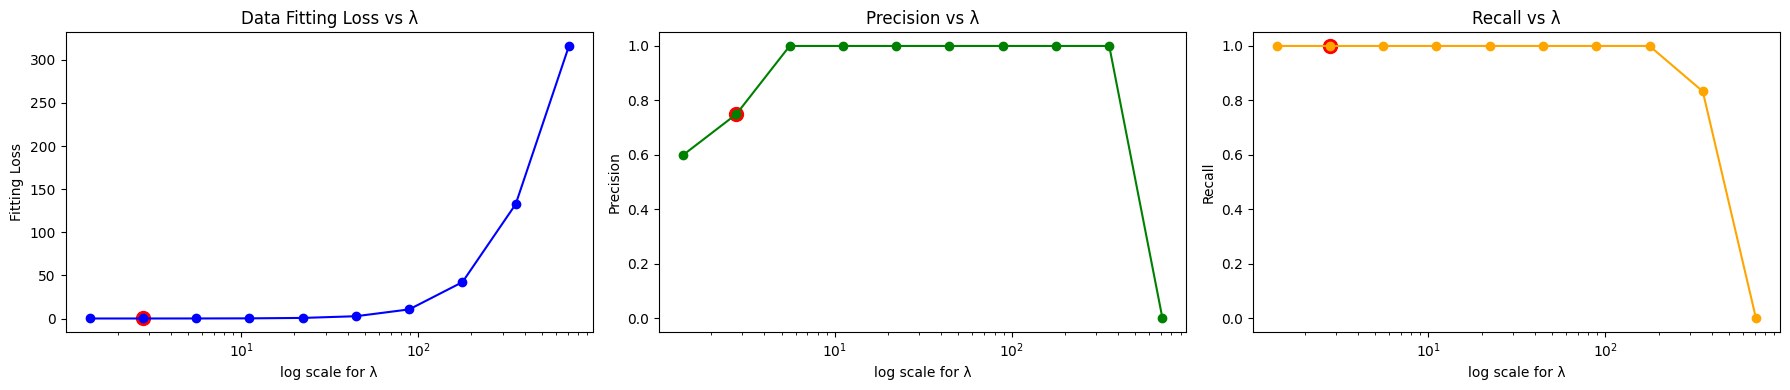

In [9]:
# TODO: Plot the following quantities as a function of λ (using log scale for λ):
# (a) Data fitting loss
# (b) Precision
# (c) Recall

plt.figure(figsize=(18, 4))

plt.subplot(1, 3, 1)
# TODO: Plot fitting loss vs. lambda
plt.semilogx(lambdas, fitting_losses, 'o-', color='blue')
plt.scatter(best_lambda, fitting_losses[best_idx], color='red', s=100)
plt.xlabel("log scale for λ")
plt.ylabel("Fitting Loss")
plt.title("Data Fitting Loss vs λ")

plt.subplot(1, 3, 2)
# TODO: Plot precision vs. lambda
plt.semilogx(lambdas, precisions, 'o-', color='green')
plt.scatter(best_lambda, precisions[best_idx], color='red', s=100)
plt.xlabel("log scale for λ")
plt.ylabel("Precision")
plt.title("Precision vs λ")

plt.subplot(1, 3, 3)
# TODO: Plot recall vs. lambda
plt.semilogx(lambdas, recalls, 'o-', color='orange')
plt.scatter(best_lambda, recalls[best_idx], color='red', s=100)
plt.xlabel("log scale for λ")
plt.ylabel("Recall")
plt.title("Recall vs λ")

plt.tight_layout()
plt.show()


# 2.3 Solve a Real-world Problem: Water Quality Prediction [30 Pts]
## 2.3.1. Data Loading and Preprocessing [10 pts]

In [10]:
def prepare_dataset(X_train_raw, X_test_raw, y_train_raw, y_test_raw, loc=0):
    """
    Prepares a dataset where each input is a flattened 37x11 matrix (all locations & features),
    and the target is the pH at a specific location (default: loc=0).
    
    Returns:
        - X_train, X_val, X_test
        - y_train, y_val, y_test
        - X_train_full, y_train_full
    """
    
    # TODO: Extract dimensions of each feature matrix
    num_locations, num_features = 37, 11  # should be 37, 11
    num_train_full = X_train_raw.shape[1]
    num_test = X_test_raw.shape[1]

    # TODO: Allocate space for flattened feature matrices
    X_train_full = np.zeros((num_train_full, num_locations * num_features))
    X_test = np.zeros((num_test, num_locations * num_features))

    # TODO: Flatten each 37x11 matrix at each timestep into a 1D feature vector
    for i in range(num_train_full):
        X_train_full[i, :] = X_train_raw[0][i].flatten()
    for i in range(num_test):
        X_test[i, :] = X_test_raw[0][i].flatten()

    # TODO: Extract pH target at location `loc`
    y_train_full = y_train_raw[loc, :].T
    y_test = y_test_raw[loc, :].T

    # TODO: Split training data into train and validation sets (80/20 split)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=0.2, random_state=0
    )

    return X_train, X_val, X_test, y_train, y_val, y_test, X_train_full, y_train_full

In [11]:
# Load data
data_file = "water_dataset.mat"
data = scipy.io.loadmat(data_file)

X_train_raw, X_test_raw = data['X_tr'], data['X_te']
y_train_raw, y_test_raw = data['Y_tr'], data['Y_te']

# Preprocess Dataset. This flattens spatial features and extracts target pH at loc=0
(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    X_train_full, y_train_full
) = prepare_dataset(X_train_raw, X_test_raw, y_train_raw, y_test_raw, loc=0)

In [12]:
# Print shape summary for sanity check
print("X_train:", X_train.shape)
print("X_val:", X_val.shape)
print("X_test:", X_test.shape)
print("X_train_full:", X_train_full.shape)
print("y_train:", y_train.shape)
print("y_val:", y_val.shape)
print("y_test:", y_test.shape)
print("y_train_full:", y_train_full.shape)

X_train: (338, 407)
X_val: (85, 407)
X_test: (282, 407)
X_train_full: (423, 407)
y_train: (338,)
y_val: (85,)
y_test: (282,)
y_train_full: (423,)


In [13]:
# Access the 'features' field
features = data['features']  # shape: (1, 11)

# Convert from nested MATLAB string format to Python list
feature_names = [str(f[0]) for f in features[0]]

# Print the feature list
print("List of 11 features:")
for i, name in enumerate(feature_names):
    print(f"{i+1}. {name}")

List of 11 features:
1. Specific conductance, water, unfiltered, microsiemens per centimeter at 25 degrees Celsius (Maximum)
2. pH, water, unfiltered, field, standard units (Maximum)
3. pH, water, unfiltered, field, standard units (Minimum)
4. Specific conductance, water, unfiltered, microsiemens per centimeter at 25 degrees Celsius (Minimum)
5. Specific conductance, water, unfiltered, microsiemens per centimeter at 25 degrees Celsius (Mean)
6. Dissolved oxygen, water, unfiltered, milligrams per liter (Maximum)
7. Dissolved oxygen, water, unfiltered, milligrams per liter (Mean)
8. Dissolved oxygen, water, unfiltered, milligrams per liter (Minimum)
9. Temperature, water, degrees Celsius (Mean)
10. Temperature, water, degrees Celsius (Minimum)
11. Temperature, water, degrees Celsius (Maximum)


In [14]:
def add_bias_column(X):
    return np.hstack([X, np.ones((X.shape[0], 1))])

# Add Bias Column (Augmented version of X
X_train_aug = add_bias_column(X_train)
X_val_aug = add_bias_column(X_val)
X_test_aug = add_bias_column(X_test)
X_train_full_aug = add_bias_column(X_train_full)

# Flatten targets for use in numpy ops
y_train = y_train.flatten()
y_val = y_val.flatten()
y_test = y_test.flatten()
y_train_full = y_train_full.flatten()

## 2.3.2 Training, Model Selection, and Testing [20 Pts]
### 2.3.2-1 Train with multiple $\lambda$ [5 pts]

In [15]:
def compute_rmse(y, ypred):
    return np.sqrt(np.mean((y - ypred) ** 2))

In [16]:
# === LASSO Validation Experiment ===

# Define lambda values (geometric decay)
lambda_max = np.linalg.norm(X_train_aug.T @ (y_train - np.mean(y_train)), ord=np.inf) / 2
n_lambdas = 5
lambdas = [lambda_max * (0.5 ** i) for i in range(n_lambdas)]
print("λ values:", [round(float(l), 3) for l in lambdas])

# Step size for ISTA
alpha = 1.0 / np.linalg.norm(X_train_aug, ord=2) ** 2

# Initialize
val_rmses = []
train_rmses = []
nonzero_counts = []
solutions = []

w_init = np.zeros(X_train_aug.shape[1])  # initial point

# TODO: Loop over each lambda and compute Lasso solution and metrics
for lam in lambdas:
    # TODO: Run ISTA with current λ (warm start from previous w_init)
    w_hat, loss_curve = ista(X_train_full_aug, y_train_full, lam, alpha, w_init, return_loss_curve=True)  # ← call ista()

    # TODO: Update w_init for warm start
    w_init = w_hat

    # TODO: Predict and compute RMSE on train and validation
    y_train_pred = X_train_aug @ w_hat
    rmse_train = np.sqrt(np.mean((y_train - y_train_pred)**2))

    y_val_pred = X_val_aug @ w_hat
    rmse_val = np.sqrt(np.mean((y_val - y_val_pred)**2))

    # TODO: Count number of nonzero weights (exclude bias)
    nnz = np.sum(np.abs(w_hat[:-1]) > 1e-5)

    # Store results
    train_rmses.append(rmse_train)
    val_rmses.append(rmse_val)
    nonzero_counts.append(nnz)
    solutions.append(w_hat)
    # print(loss_curve)


λ values: [0.219, 0.11, 0.055, 0.027, 0.014]


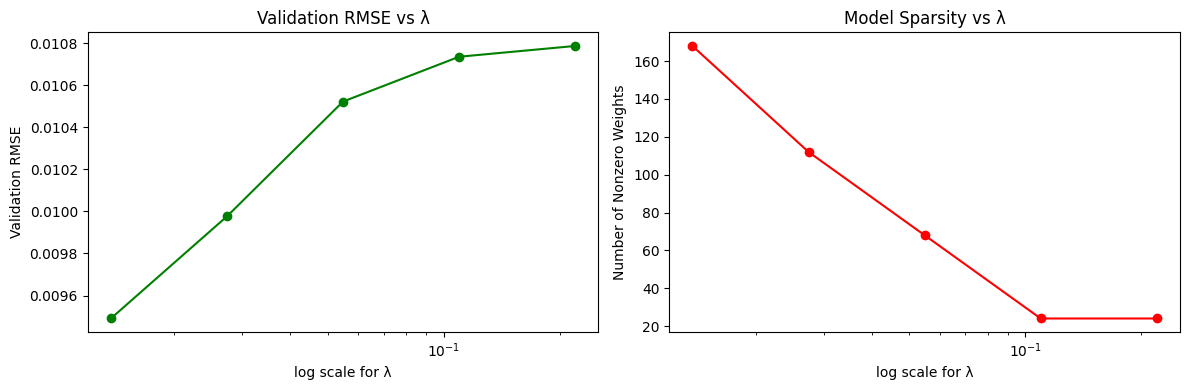

In [17]:
# TODO: Generate two plots: validation RMSE vs. lambda and sparsity vs. lambda

plt.figure(figsize=(12, 4))  # Adjust size as needed

# ----- Subplot 1: Validation RMSE -----
plt.subplot(1, 2, 1)
plt.semilogx(lambdas, val_rmses, 'o-', color='green')
plt.xlabel("log scale for λ")
plt.ylabel("Validation RMSE")
plt.title("Validation RMSE vs λ")

# ----- Subplot 2: Sparsity -----
plt.subplot(1, 2, 2)
plt.semilogx(lambdas, nonzero_counts, 'o-', color='red')
plt.xlabel("log scale for λ")
plt.ylabel("Number of Nonzero Weights")
plt.title("Model Sparsity vs λ")
plt.tight_layout()
plt.show()



### 2.3.2-2 Select two candidate $\lambda$ values [5 pts]

In [18]:
def select_lambda_candidates(lambdas, val_rmses, nonzero_counts, rmse_tol=0.1):
    """
    Select lambda values based on two criteria:
    Option A: lowest validation RMSE
    Option B: sparsest model

    Returns:
        lambda_A, lambda_B, index_A, index_B
    """

    # TODO: Option A — λ with the lowest validation RMSE
    idx_A = np.argmin(val_rmses)  # ← use np.argmin
    lambda_A = lambdas[idx_A]
    best_rmse = val_rmses[idx_A]

    # TODO: Option B — λ with the fewest nonzero weights (most sparse)
    idx_B = np.argmin(nnz)
    lambda_B = lambdas[idx_B]

    # Print summary of both options
    print("Option A (lowest RMSE):")
    print(f"  λ = {lambda_A:.4f}, RMSE = {val_rmses[idx_A]:.4f}, Nonzeros = {nonzero_counts[idx_A]}")
    print("Option B (most sparse):")
    print(f"  λ = {lambda_B:.4f}, RMSE = {val_rmses[idx_B]:.4f}, Nonzeros = {nonzero_counts[idx_B]}")

    return lambda_A, lambda_B, idx_A, idx_B


In [19]:
lambda_A, lambda_B, idx_A, idx_B = select_lambda_candidates(
    lambdas=lambdas,
    val_rmses=val_rmses,
    nonzero_counts=nonzero_counts
)

Option A (lowest RMSE):
  λ = 0.0137, RMSE = 0.0095, Nonzeros = 168
Option B (most sparse):
  λ = 0.2194, RMSE = 0.0108, Nonzeros = 24


### 2.3.2-3 Retrain on the full training set [5 pts]

In [20]:
def compute_lasso_components(X, y, w, lambd):
    """
    Compute different components of the LASSO objective.
    """
    N = len(y)
    y_pred = X @ w
    res = y - y_pred
    data_fitting_loss = 0.5 / N * np.sum(res ** 2)
    l1_penalty = lambd * np.sum(np.abs(w[:-1]))  # exclude bias
    total_loss = data_fitting_loss + l1_penalty
    num_nonzero = np.sum(np.abs(w[:-1]) > 1e-6)  # count nonzero weights only (ignore bias)
    return data_fitting_loss, l1_penalty, total_loss, num_nonzero


In [21]:
# Full training set
X_full = X_train_full_aug
y_full = y_train_full

# Step size and init
alpha = 1 / (np.linalg.norm(X_full, 2) ** 2)
w_init = np.zeros(X_full.shape[1])

# TODO: Retrain at lambda_A using ISTA
w_A, loss_curve_A = ista(X_train_full_aug, y_train_full, lambda_A, alpha, w_init, return_loss_curve=True)  # ← call ista()
fit_A, reg_A, total_A, nnz_A = compute_lasso_components(X_full, y_full, w_A, lambda_A)
# TODO: Retrain at lambda_B using ISTA
w_B, loss_curve_B = ista(X_train_full_aug, y_train_full, lambda_B, alpha, w_init, return_loss_curve=True)  # ← call ista()
fit_B, reg_B, total_B, nnz_B = compute_lasso_components(X_full, y_full, w_B, lambda_B)


In [22]:
# Print summary table for retrained models
models = {
    'λ_A (Best RMSE)': (lambda_A, w_A),
    'λ_B (Sparsest)': (lambda_B, w_B)
}

print(f"{'Model':<20} {'λ':>10} {'Data Fit Loss':>18} {'L1 Penalty':>15} {'Total Loss':>15} {'# Nonzeros':>12}")
print("-" * 95)

for label, (lam, w_hat) in models.items():
    fit_loss, l1_penalty, total_loss, nnz = compute_lasso_components(X_train_full_aug, y_train_full, w_hat, lam)
    print(f"{label:<20} {lam:10.4f} {fit_loss:18.6f} {l1_penalty:15.6f} {total_loss:15.6f} {nnz:12d}")


Model                         λ      Data Fit Loss      L1 Penalty      Total Loss   # Nonzeros
-----------------------------------------------------------------------------------------------
λ_A (Best RMSE)          0.0137           0.000044        0.013934        0.013979          267
λ_B (Sparsest)           0.2194           0.000046        0.113295        0.113341           38


### 2.3.2-4 Plot training curves [2 pts]

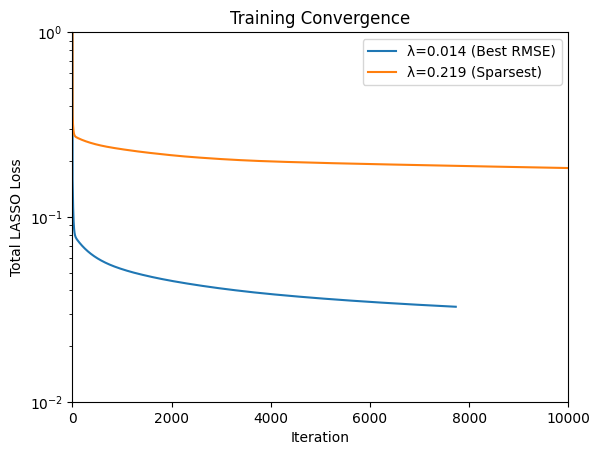

In [23]:
# Plot training convergence curves
plt.figure()
plt.semilogy(loss_curve_A, label=f"λ={lambda_A:.3f} (Best RMSE)")
plt.semilogy(loss_curve_B, label=f"λ={lambda_B:.3f} (Sparsest)")
plt.xlabel("Iteration")
plt.xlim(0, 10000)
plt.ylabel("Total LASSO Loss")
plt.ylim(1e-2,1)
plt.title("Training Convergence")
plt.legend()
plt.show()


### 2.3.2-5 Evaluate on test data [3 pts]

In [24]:
# TODO: Use your retrained models w_A and w_B to predict on the test set
# Hint: Use the test feature matrix X_test_aug (with bias column)

# TODO: Predict
y_test_pred_A = X_test_aug @ w_A
y_test_pred_B = X_test_aug @ w_B

# TODO: Compute RMSE on the test set
test_rmse_A = np.sqrt(np.mean((y_test - y_test_pred_A)**2))
test_rmse_B = np.sqrt(np.mean((y_test - y_test_pred_B)**2))

print(f"Test RMSE (Option A - Best RMSE): {test_rmse_A:.4f}")
print(f"Test RMSE (Option B - Sparsest): {test_rmse_B:.4f}")


# TODO: Discuss which model generalizes better to unseen data
if test_rmse_A < test_rmse_B:
    print("Option A - Lowest validation RMSE is better to unseen data")
elif test_rmse_A > test_rmse_B:
    print("Option B - Most sparse weight is better to unseen data")
else:
    print("The performance of option A and option B are the same.")


Test RMSE (Option A - Best RMSE): 0.0112
Test RMSE (Option B - Sparsest): 0.0098
Option B - Most sparse weight is better to unseen data
